In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

from shapely.geometry import Polygon

import iceplant_detection_functions as ipf

In [2]:
from imblearn.over_sampling import SMOTE

In [3]:
#!pip install -U imbalanced-learn
#https://imbalanced-learn.org/stable/install.html#getting-started

# AREAS OF INTEREST

In [4]:
aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))
cp = aois.iloc[0]  # Campus Lagoon aoi

# ASSEMBLE DATA

All points in the training set were collected in a single NAIP image, 
id = cp.itemid

In [5]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_trees','trainset_trees.csv')
trees_df = pd.read_csv(fp)
#trees_df.head(1)
trees_df.shape

(395, 9)

In [6]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_non_iceplant_vegetation.csv')
noniceplant_features_df = pd.read_csv(fp)
#noniceplant_features_df.head(1)
noniceplant_features_df.shape

(193345, 9)

In [7]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_BIG.csv')
features_df = pd.read_csv(fp)
#features_df.head(1)
features_df.shape

(4789, 9)

In [8]:
# add non-iceplant vegetation points sample to BIG training set 
features_df = pd.concat([features_df,
                         noniceplant_features_df.sample(frac=0.8),
                    #     noniceplant_features_df,
                         trees_df])
features_df.drop(['geometry','Unnamed: 0','x','y'],axis=1,inplace=True)
ipf.iceplant_proportions(features_df.iceplant.to_numpy())

no-iceplant:iceplant ratio     98.4 :1
          counts  percentage
iceplant                    
0         158251       98.99
1           1609        1.01



# SPLIT INTO TRAIN/TEST

In [9]:
train_features, test_features, train_labels, test_labels = ipf.test_train_from_df(features_df)

ipf.train_test_shapes(train_features, train_labels, test_features, test_labels)
ipf.test_train_proportions(train_labels, test_labels)

Training Features Shape: (111902, 4)
Training Labels Shape: (111902,)
Testing Features Shape: (47958, 4)
Testing Labels Shape: (47958,)

TRAIN SET COUNTS:
no-iceplant:iceplant ratio     99.3 :1
          counts  percentage
iceplant                    
0         110786        99.0
1           1116         1.0

TEST SET COUNTS:
no-iceplant:iceplant ratio     96.3 :1
          counts  percentage
iceplant                    
0          47465       98.97
1            493        1.03



# NAIVE MODEL: classify everything according to binomial distribution

In [10]:
#all0 = np.ones(shape=test_labels.shape, dtype='int8')
rand = np.random.binomial(1,0.5,size=test_labels.shape)
ipf.print_threshold_metrics(test_labels, rand)



true negatives: 23761     false positives: 23704
false negatives: 266     true positives: 227

sensitivity (TP/P): 46.04 %
specificity (TN/N): 50.06 %
G-mean:  0.48

precision (TP/(TP+FP)): 0.01 %

MCC:  -0.007858223432707676

F1-measure:  0.01859
F0.5-measure (min false positives):  0.0118
F2-measure (min false negatives)  :  0.04382

accuracy: 50.02 %



# MODEL: standard rfc with complete training set
- covariates: r,g, b, nir
- trained on previous set (bigger set than original TRIALS_random forest)
- predictions are only made over NDVI>0.2

In [11]:
# rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
# rfc.fit(train_features,train_labels)

# predictions = rfc.predict(test_features)

# ipf.print_threshold_metrics(rfc, test_features, test_labels, predictions)

# MODEL: standard rfc with 80% of non_iceplant features

In [12]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_features,train_labels)

predictions = rfc.predict(test_features)

ipf.print_threshold_metrics(test_labels, predictions)


true negatives: 47382     false positives: 83
false negatives: 129     true positives: 364

sensitivity (TP/P): 73.83 %
specificity (TN/N): 99.83 %
G-mean:  0.86

precision (TP/(TP+FP)): 0.81 %

MCC:  0.7731860823526732

F1-measure:  0.77447
F0.5-measure (min false positives):  0.7979
F2-measure (min false negatives)  :  0.75238

accuracy: 99.56 %



# MODEL: rfc with class weighting (balanced rfc)
- class_weight = balanced in rfc model

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [13]:
rfc_balanced = RandomForestClassifier(n_estimators = 100, 
                                      random_state = 42,
                                      class_weight='balanced')
rfc_balanced.fit(train_features,train_labels)
predictions_balanced = rfc_balanced.predict(test_features)
ipf.print_threshold_metrics(test_labels, predictions_balanced)


true negatives: 47397     false positives: 68
false negatives: 137     true positives: 356

sensitivity (TP/P): 72.21 %
specificity (TN/N): 99.86 %
G-mean:  0.85

precision (TP/(TP+FP)): 0.84 %

MCC:  0.7765433306596904

F1-measure:  0.77644
F0.5-measure (min false positives):  0.81316
F2-measure (min false negatives)  :  0.7429

accuracy: 99.57 %



/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


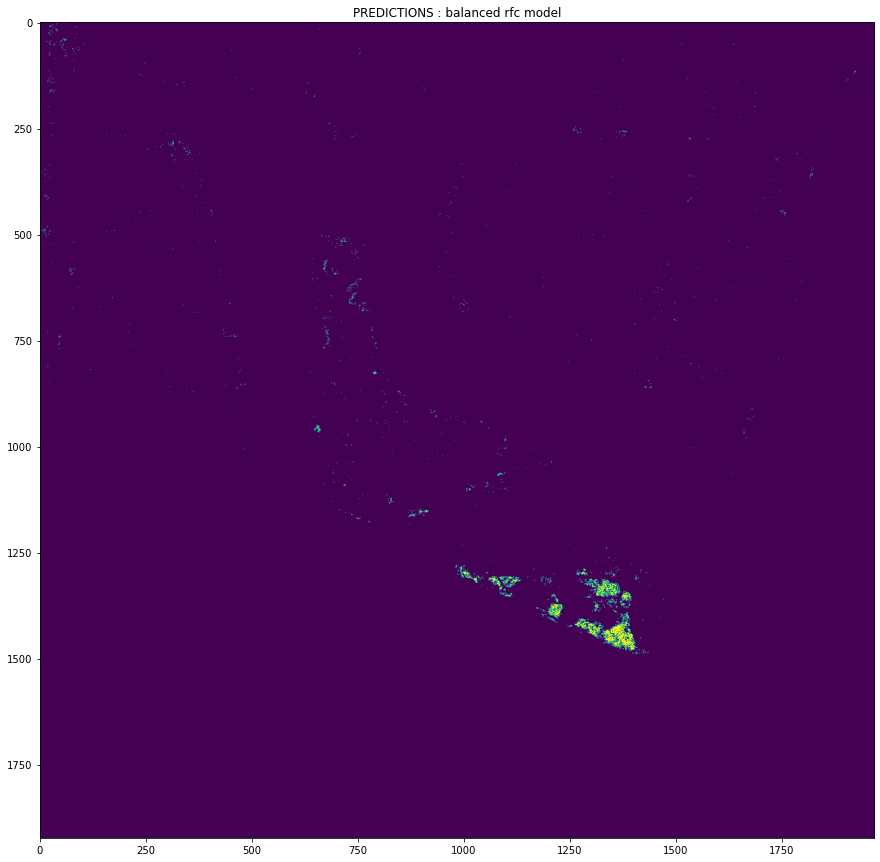

In [14]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry,rfc_balanced)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : balanced rfc model")
ax.imshow(reconstructed)
plt.show()

# MODEL: standard rfc + SMOTE(10:1)
- covariates: r,g, b, nir
- trained on previous set (bigger set than original TRIALS_random forest)
- SMOTE oversampling used to deal with class imbalance

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html?highlight=smote#imblearn.over_sampling.SMOTE

- predictions are only made over NDVI>0.2

In [15]:
oversample = SMOTE(sampling_strategy=0.1)
over_train_features, over_train_labels = oversample.fit_resample(train_features, train_labels)
ipf.iceplant_proportions(over_train_labels)

no-iceplant:iceplant ratio     10.0 :1
          counts  percentage
iceplant                    
0         110786       90.91
1          11078        9.09



In [16]:
smote_srf = RandomForestClassifier(n_estimators=100, 
                                   random_state=42)
smote_srf.fit(over_train_features, over_train_labels)

smote_predictions = smote_srf.predict(test_features)

ipf.print_threshold_metrics(test_labels, smote_predictions)


true negatives: 47300     false positives: 165
false negatives: 85     true positives: 408

sensitivity (TP/P): 82.76 %
specificity (TN/N): 99.65 %
G-mean:  0.91

precision (TP/(TP+FP)): 0.71 %

MCC:  0.7650637280404169

F1-measure:  0.76548
F0.5-measure (min false positives):  0.7325
F2-measure (min false negatives)  :  0.80157

accuracy: 99.48 %



# MODEL: standard rfc +SMOTE(4:1)

In [17]:
oversample = SMOTE(sampling_strategy=0.25)
over_train_features, over_train_labels = oversample.fit_resample(train_features, train_labels)
ipf.iceplant_proportions(over_train_labels)

no-iceplant:iceplant ratio     4.0 :1
          counts  percentage
iceplant                    
0         110786        80.0
1          27696        20.0



In [18]:
smote_srf25 = RandomForestClassifier(n_estimators=100, 
                                   random_state=42)
#Train SMOTE + undersample rfc
smote_srf25.fit(over_train_features, over_train_labels)

smote25_predictions = smote_srf25.predict(test_features)

ipf.print_threshold_metrics(test_labels, smote25_predictions)


true negatives: 47256     false positives: 209
false negatives: 85     true positives: 408

sensitivity (TP/P): 82.76 %
specificity (TN/N): 99.56 %
G-mean:  0.91

precision (TP/(TP+FP)): 0.66 %

MCC:  0.7367926412347897

F1-measure:  0.73514
F0.5-measure (min false positives):  0.68896
F2-measure (min false negatives)  :  0.78795

accuracy: 99.39 %



/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


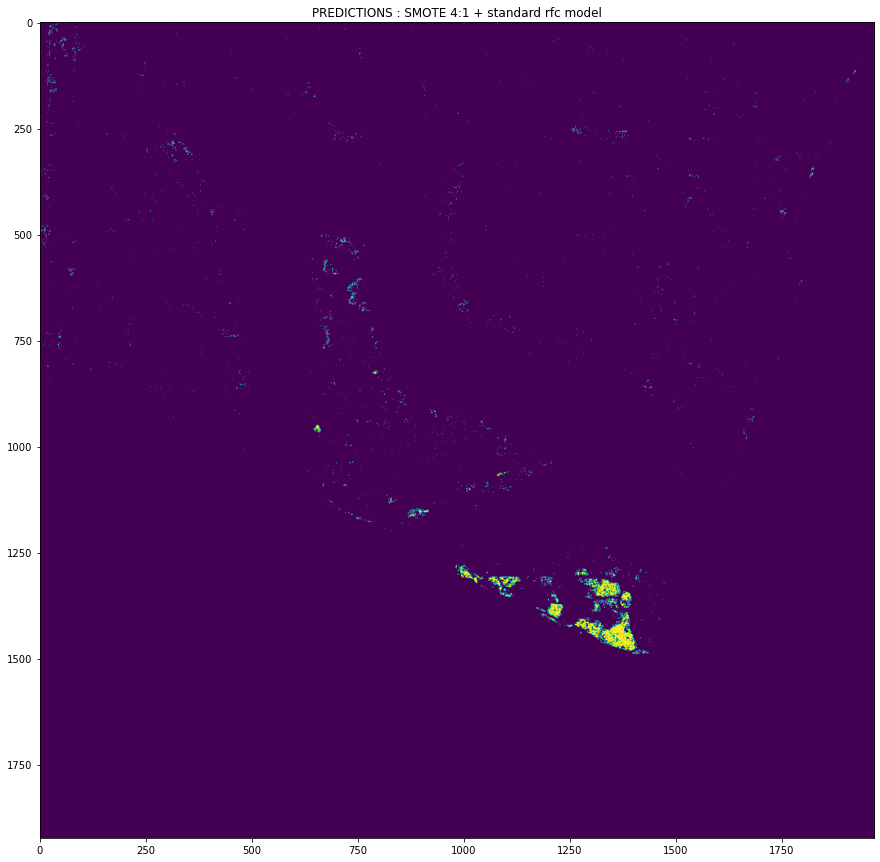

In [19]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry,smote_srf25)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : SMOTE 4:1 + standard rfc model")
ax.imshow(reconstructed)
plt.show()

# MODEL: standard rfc +SMOTE(2:1)

In [20]:
oversample = SMOTE(sampling_strategy=0.5)
over_train_features, over_train_labels = oversample.fit_resample(train_features, train_labels)
ipf.iceplant_proportions(over_train_labels)

no-iceplant:iceplant ratio     2.0 :1
          counts  percentage
iceplant                    
0         110786       66.67
1          55393       33.33



In [21]:
smote_srf5 = RandomForestClassifier(n_estimators=100, 
                                   random_state=42)
#Train SMOTE + undersample rfc
smote_srf5.fit(over_train_features, over_train_labels)

smote5_predictions = smote_srf5.predict(test_features)

ipf.print_threshold_metrics(test_labels, smote5_predictions)


true negatives: 47241     false positives: 224
false negatives: 77     true positives: 416

sensitivity (TP/P): 84.38 %
specificity (TN/N): 99.53 %
G-mean:  0.92

precision (TP/(TP+FP)): 0.65 %

MCC:  0.7375945572160935

F1-measure:  0.73433
F0.5-measure (min false positives):  0.6813
F2-measure (min false negatives)  :  0.79632

accuracy: 99.37 %



# MODEL: SMOTE(10:1) + random undersampling(4:1) + standard rfc

In [22]:
# oversample train sets with SMOTE
oversample = SMOTE(sampling_strategy=0.1)
over_train_features, over_train_labels = oversample.fit_resample(train_features, train_labels)
ipf.iceplant_proportions(over_train_labels)

no-iceplant:iceplant ratio     10.0 :1
          counts  percentage
iceplant                    
0         110786       90.91
1          11078        9.09



In [23]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy=0.25)
under_train_features, under_train_labels = undersample.fit_resample(over_train_features, over_train_labels)

ipf.iceplant_proportions(under_train_labels)

no-iceplant:iceplant ratio     4.0 :1
          counts  percentage
iceplant                    
0          44312        80.0
1          11078        20.0



In [24]:
resample_SRF = RandomForestClassifier(n_estimators=100, random_state=42)

#Train standard rfc on SMOTE + undersample trainset
resample_SRF.fit(under_train_features, under_train_labels)

resample_predictions = resample_SRF.predict(test_features)

ipf.print_threshold_metrics(test_labels, resample_predictions)


true negatives: 47140     false positives: 325
false negatives: 58     true positives: 435

sensitivity (TP/P): 88.24 %
specificity (TN/N): 99.32 %
G-mean:  0.94

precision (TP/(TP+FP)): 0.57 %

MCC:  0.7071322281148887

F1-measure:  0.69433
F0.5-measure (min false positives):  0.61562
F2-measure (min false negatives)  :  0.79612

accuracy: 99.2 %



# MODEL: balanced rfc + SMOTE(10:1)

In [27]:
oversample = SMOTE(sampling_strategy=0.25)
over_train_features, over_train_labels = oversample.fit_resample(train_features, train_labels)
ipf.iceplant_proportions(over_train_labels)

no-iceplant:iceplant ratio     4.0 :1
          counts  percentage
iceplant                    
0         110786        80.0
1          27696        20.0



In [28]:
smote_brf = RandomForestClassifier(n_estimators=100,
                                   class_weight = 'balanced',
                                   random_state=42)
#Train SMOTE + undersample rfc
smote_brf.fit(over_train_features, over_train_labels)

smote_predictions = smote_brf.predict(test_features)

ipf.print_threshold_metrics(test_labels, smote_predictions)


true negatives: 47264     false positives: 201
false negatives: 83     true positives: 410

sensitivity (TP/P): 83.16 %
specificity (TN/N): 99.58 %
G-mean:  0.91

precision (TP/(TP+FP)): 0.67 %

MCC:  0.7441547161528298

F1-measure:  0.74275
F0.5-measure (min false positives):  0.69799
F2-measure (min false negatives)  :  0.79365

accuracy: 99.41 %



# Logistic regression model?

In [ ]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(train_features, train_labels)

log_predictions = logisticRegr.predict(test_features)
ipf.print_threshold_metrics(test_labels, log_predictions)

In [29]:
train_features

array([[ 98, 103, 107, 125],
       [ 63,  61,  70,  98],
       [ 28,  41,  57,  97],
       ...,
       [ 72,  79,  80, 168],
       [ 58,  72,  75, 163],
       [ 35,  44,  61,  53]])

In [34]:
test_data = pd.DataFrame(test_features,columns=['r','g','b','nir'])
test_data['iceplant']=test_labels
test_data

,r,g,b,nir,iceplant
0,116,101,92,141,0
1,43,56,69,119,0
2,206,208,203,191,0
3,63,85,75,185,0
4,163,140,121,176,0
...,...,...,...,...,...
47953,121,109,97,130,0
47954,65,77,76,173,0
47955,113,102,101,103,0
47956,62,65,72,131,0


In [37]:
test_data.to_csv(os.path.join(os.getcwd(),'test_data.csv'))

In [35]:
os.getcwd()

'/home/jovyan/msai4earth-esa/iceplant_detection'